# Lab4: Sentiment with GRUs

In this assignment, you'll convert the RNN sentiment classifier from last time into a **GRU** RNN sentiment classifier. While the small dataset and tiny vocabulary that we're using here (for speed) will limit the performance of the model, it should still do substantially better than the plain RNN.

![](http://vignette1.wikia.nocookie.net/despicableme/images/b/ba/Gru.jpg/revision/latest/scale-to-width-down/250?cb=20130711023954)

## Setup

First, let's load the data as before.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import re
import random

# Let's do 2-way positive/negative classification instead of 5-way
def load_sst_data(path,
                  easy_label_map={0:0, 1:0, 2:None, 3:1, 4:1}):
    data = []
    with open(path) as f:
        for i, line in enumerate(f): 
            example = {}
            example['label'] = easy_label_map[int(line[1])]
            if example['label'] is None:
                continue
            
            # Strip out the parse information and the phrase labels--
            # ---we don't need those here
            text = re.sub(r'\s*(\(\d)|(\))\s*', '', line)
            example['text'] = text[1:]
            data.append(example)
    
    random.seed(1)
    random.shuffle(data)
    return data
   
sst_home = 'drive/My Drive/Colab Notebooks/dl4nlp_labs/data/trees/'
training_set = load_sst_data(sst_home + '/train.txt')
dev_set = load_sst_data(sst_home + '/dev.txt')
test_set = load_sst_data(sst_home + '/test.txt')

# Note: Unlike with k-nearest neighbors, evaluation here should be fast, and we don't need to
# trim down the dev and test sets. 

Next, we'll convert the data to index vectors.

To simplify your implementation, we'll use a fixed unrolling length of 20. In the conversion process, we'll cut off excess words (towards the left/start end of the sentence), pad short sentences (to the left) with a special word symbol `<PAD>`, and mark out-of-vocabulary words with `<UNK>`, for unknown. As in the previous assignment, we'll use a very small vocabulary for this assignment, so you'll see `<UNK>` often.

In [3]:
import collections
import numpy as np

def sentence_to_padded_index_sequence(datasets):
    '''Annotates datasets with feature vectors.'''
    

    PADDING = "<PAD>"
    UNKNOWN = "<UNK>"
    SEQ_LEN = 20
    
    # Extract vocabulary
    def tokenize(string):
        return string.lower().split()
    
    word_counter = collections.Counter()
    for example in datasets[0]:
        word_counter.update(tokenize(example['text']))
    
    vocabulary = set([word for word in word_counter if word_counter[word] > 10])
    vocabulary = list(vocabulary)
    vocabulary = [PADDING, UNKNOWN] + vocabulary
        
    word_indices = dict(zip(vocabulary, range(len(vocabulary))))
    indices_to_words = {v: k for k, v in word_indices.items()}
        
    for i, dataset in enumerate(datasets):
        for example in dataset:
            example['index_sequence'] = np.zeros((SEQ_LEN), dtype=np.int32)
            
            token_sequence = tokenize(example['text'])
            padding = SEQ_LEN - len(token_sequence)
            
            for i in range(SEQ_LEN):
                if i >= padding:
                    if token_sequence[i - padding] in word_indices:
                        index = word_indices[token_sequence[i - padding]]
                    else:
                        index = word_indices[UNKNOWN]
                else:
                    index = word_indices[PADDING]
                example['index_sequence'][i] = index
    return indices_to_words, word_indices
    
indices_to_words, word_indices = sentence_to_padded_index_sequence([training_set, dev_set, test_set])

In [4]:
print(training_set[18])
print(len(word_indices))

{'label': 1, 'text': 'As the dominant Christine , Sylvie Testud is icily brilliant .', 'index_sequence': array([   0,    0,    0,    0,    0,    0,    0,    0,    0,  208, 1092,
          1,    1,  667,    1,    1,  141,    1, 1025,  742], dtype=int32)}
1250


In [5]:
def evaluate_classifier(classifier, eval_set):
    correct = 0
    hypotheses = classifier(eval_set)
    for i, example in enumerate(eval_set):
        hypothesis = hypotheses[i]
        if hypothesis == example['label']:
            correct += 1        
    return correct / float(len(eval_set))

## Assignments: Building the RNN

The class below is a solved version of last week's RNN exercise. The only change I've made is to increase the learning rate, since GRUs are less likely to do crazy things during optimization. Your job is to convert it into a GRU model. You should have to:

- **TODO1**: Add additional trained parameters.
- **TODO2**: Modify the `step()` function.
- **TODO3**: Modify L2 regularization to incorporate the new parameters.

You shouldn't have to edit anything outside of `__init__()`.

In [6]:
%tensorflow_version 2.x
!pip install tensorflow==2.4.0
import tensorflow as tf
tf.__version__

     |████████████████████████████████| 394.7 MB 18 kB/s 
     |████████████████████████████████| 462 kB 50.3 MB/s 
     |████████████████████████████████| 3.8 MB 32.3 MB/s 
     |████████████████████████████████| 2.9 MB 35.4 MB/s 
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=68716 sha256=8e7a4c78b90ccc542bda81bfa83d4b001782808ed76f30ae5834787b3e442177
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.43.0
    Uninstalling grpcio-1.43.0:
      Successfully uninstalled grpcio-1.43.0
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.13.3
    Uninstalling wrapt-1.13.3:
      Suc

'2.4.0'

In [7]:
class RNNSentimentClassifier:
    def __init__(self, vocab_size, sequence_length):
        # Define the hyperparameters
        self.learning_rate = 1.0  # Should be about right
        self.training_epochs = 500  # How long to train for - chosen to fit within class time
        self.display_epoch_freq = 5  # How often to test and print out statistics
        self.dim = 12  # The dimension of the hidden state of the RNN
        self.embedding_dim = 8  # The dimension of the learned word embeddings
        self.batch_size = 256  # Somewhat arbitrary - can be tuned, but often tune for speed, not accuracy
        self.vocab_size = vocab_size  # Defined by the file reader above
        self.sequence_length = sequence_length  # Defined by the file reader above
        self.l2_lambda = 0.001
        
        self.trainable_variables = []

        # Define the parameters
        self.E = tf.Variable(tf.random.normal([self.vocab_size, self.embedding_dim], stddev=0.1))
        self.trainable_variables.append(self.E)

        self.W_rnn = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_rnn = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_rnn)
        self.trainable_variables.append(self.b_rnn)
        
        self.W_cl = tf.Variable(tf.random.normal([self.dim, 2], stddev=0.1))
        self.b_cl = tf.Variable(tf.random.normal([2], stddev=0.1))
        self.trainable_variables.append(self.W_cl)
        self.trainable_variables.append(self.b_cl)
        
        # TODO1: Add additional GRU parameters
        
        self.W_z = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_z = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.W_r = tf.Variable(tf.random.normal([self.embedding_dim + self.dim, self.dim], stddev=0.1))
        self.b_r = tf.Variable(tf.random.normal([self.dim], stddev=0.1))
        self.trainable_variables.append(self.W_z)
        self.trainable_variables.append(self.b_z)
        self.trainable_variables.append(self.W_r)
        self.trainable_variables.append(self.b_r)
        
        
    def model(self,x):
        # Split up the inputs into individual tensors
        self.x_slices = tf.split(x, self.sequence_length, 1)
        
        self.h_zero = tf.zeros([self.batch_size, self.dim])

        # Define one step of the RNN
        # TODO2: Modify the step() function to compute GRU step
        def step(x, h_prev):
            emb = tf.nn.embedding_lookup(params=self.E,ids=x)
            emb_h_prev = tf.concat([emb, h_prev], 1)
            z = tf.sigmoid(tf.matmul(emb_h_prev, self.W_z) + self.b_z)
            r = tf.sigmoid(tf.matmul(emb_h_prev, self.W_r) + self.b_r)
            emb_h_r_prev = tf.concat([emb, r * h_prev], 1)
            h_tilde = tf.nn.tanh(tf.matmul(emb_h_r_prev, self.W_rnn)  + self.b_rnn)
            h =  (1. - z) * h_prev + z * h_tilde
            return h
        
        
        h_prev = self.h_zero
        
        # Unroll the RNN
        for t in range(self.sequence_length):
            x_t = tf.reshape(self.x_slices[t], [-1])
            h_prev = step(x_t, h_prev)
        
        # Compute the logits using one last linear layer
        logits = tf.matmul(h_prev, self.W_cl) + self.b_cl
        return logits
        
    def train(self, training_data, dev_set):
        def get_minibatch(dataset, start_index, end_index):
            indices = range(start_index, end_index)
            vectors = np.vstack([dataset[i]['index_sequence'] for i in indices])
            labels = [dataset[i]['label'] for i in indices]
            return vectors, labels
    
        print ('Training.')

        # Training cycle
        train_acc = []
        dev_acc = []
        epochs = []
        for epoch in range(self.training_epochs):
            random.shuffle(training_set)
            avg_cost = 0.
            total_batch = int(len(training_set) / self.batch_size)
            
            # Loop over all batches in epoch
            for i in range(total_batch):
                # Assemble a minibatch of the next B examples
                minibatch_vectors, minibatch_labels = get_minibatch(training_set, 
                                                                    self.batch_size * i, 
                                                                    self.batch_size * (i + 1))

                # Run the optimizer to take a gradient step, and also fetch the value of the 
                # cost function for logging
                with tf.GradientTape() as tape:
                  logits = self.model(minibatch_vectors)
                  # Define the L2 cost
                  # TODO3: Modify L2 regularization to incorporate the new parameters.
                  l2_cost = self.l2_lambda * (tf.reduce_sum(tf.square(self.W_rnn)) +
                                                   tf.reduce_sum(tf.square(self.W_z)) +
                                                   tf.reduce_sum(tf.square(self.W_r)) +
                                                   tf.reduce_sum(tf.square(self.W_cl)))
        
                  # Define the cost function (here, the softmax exp and sum are built in)
                  total_cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels=minibatch_labels, logits=logits) + l2_cost)
        
                # This  performs the main SGD update equation with gradient clipping
                optimizer = tf.optimizers.SGD(self.learning_rate)
                gradients = tape.gradient(total_cost, self.trainable_variables)
                gvs = zip(gradients, self.trainable_variables)
                capped_gvs = [(tf.clip_by_norm(grad, 5.0), var) for grad, var in gvs if grad is not None]
                optimizer.apply_gradients(capped_gvs)
                                  
                # Compute average loss
                avg_cost += total_cost / total_batch
                
            # Display some statistics about the step
            # Evaluating only one batch worth of data -- simplifies implementation slightly
            if (epoch+1) % self.display_epoch_freq == 0:
                dev_acc.append(evaluate_classifier(self.classify, dev_set[0:256]))
                train_acc.append(evaluate_classifier(self.classify, training_set[0:256]))
                epochs.append(epoch+1)
                tf.print("Epoch:", (epoch+1), "Cost:", avg_cost, \
                    "Dev acc:", dev_acc[-1], \
                    "Train acc:", train_acc[-1])  
        return train_acc, dev_acc, epochs
    
    def classify(self, examples):
        # This classifies a list of examples
        vectors = np.vstack([example['index_sequence'] for example in examples])
        logits = self.model(vectors)
        return np.argmax(logits, axis=1)

np.random.seed(1)
tf.random.set_seed(1)

classifier = RNNSentimentClassifier(len(word_indices), 20)

Now let's train it. If the GRU is doing what it should, you should reach 80% accuracy within your first 200 epochs—a substantial improvement over the 70% figure we saw last week.

In [8]:
train_acc, dev_acc, epochs = classifier.train(training_set, dev_set)

Training.
Epoch: 5 Cost: 0.69725877 Dev acc: 0.5546875 Train acc: 0.546875
Epoch: 10 Cost: 0.695174634 Dev acc: 0.4453125 Train acc: 0.4453125
Epoch: 15 Cost: 0.69443655 Dev acc: 0.5546875 Train acc: 0.484375
Epoch: 20 Cost: 0.693574548 Dev acc: 0.5546875 Train acc: 0.546875
Epoch: 25 Cost: 0.693251312 Dev acc: 0.5546875 Train acc: 0.50390625
Epoch: 30 Cost: 0.693100929 Dev acc: 0.4453125 Train acc: 0.42578125
Epoch: 35 Cost: 0.693528116 Dev acc: 0.5546875 Train acc: 0.58203125
Epoch: 40 Cost: 0.693743765 Dev acc: 0.5546875 Train acc: 0.546875
Epoch: 45 Cost: 0.693317711 Dev acc: 0.5546875 Train acc: 0.515625
Epoch: 50 Cost: 0.692953229 Dev acc: 0.5546875 Train acc: 0.5546875
Epoch: 55 Cost: 0.692525446 Dev acc: 0.5546875 Train acc: 0.5
Epoch: 60 Cost: 0.693791926 Dev acc: 0.5546875 Train acc: 0.484375
Epoch: 65 Cost: 0.693054318 Dev acc: 0.5546875 Train acc: 0.51953125
Epoch: 70 Cost: 0.692757189 Dev acc: 0.4453125 Train acc: 0.50390625
Epoch: 75 Cost: 0.692732036 Dev acc: 0.5546875 T

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline 

def plot_learning_curve(par_values, train_scores, dev_scores, title="Learning Curve", xlab="", ylab="Accuracy", ylim=None):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    par_values : list of checked values of the current parameter.
    
    train_scores : list of scores obtained in training set (same length as par_values).
    
    test_scores : list of scores obtained in dev set (same length as par_values)

    title : string
        Title for the chart.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel(xlab)
    plt.ylabel(ylab)
    
    plt.grid()
    plt.plot(par_values, train_scores, color="r",label="Training score")
    plt.plot(par_values, dev_scores, color="g", label="Dev score")

    plt.legend(loc="best")
    return plt

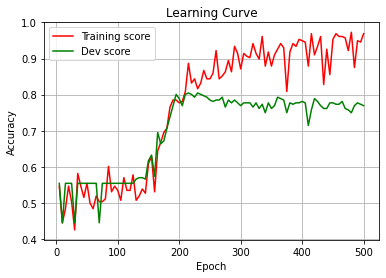

In [10]:
plt = plot_learning_curve(epochs, train_acc, dev_acc, xlab="Epoch")
plt.show()

# Atribution:
Adapted by Oier Lopez de Lacalle, Olatz Perez de Viñaspre and Ander Barrena, based on a notebook by Sam Bowman at NYU